<a href="https://colab.research.google.com/github/nphh05/SpamMessageClassification/blob/main/Ph%C3%A2n_lo%E1%BA%A1i_Text_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve, validation_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, naive_bayes,metrics
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
from nltk.stem import LancasterStemmer
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split as ttsplit
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import re # Import the 're' module for regular expressions
import string
from collections import Counter # Import the Counter class
from sklearn.metrics import classification_report # Import the classification_report function
from sklearn.svm import SVC # Import SVC explicitly
import os
import subprocess
import threading # Import the threading module
import time # Import the time module
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer
import joblib
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Tải bộ dữ liệu
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

df = pd.read_csv("spam.csv", encoding="latin-1")
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})  # Chuyển thành 0 (ham) và 1 (spam)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


<ipython-input-3-ec1de56faba3>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_Class=pd.value_counts(df["label"], sort= True)


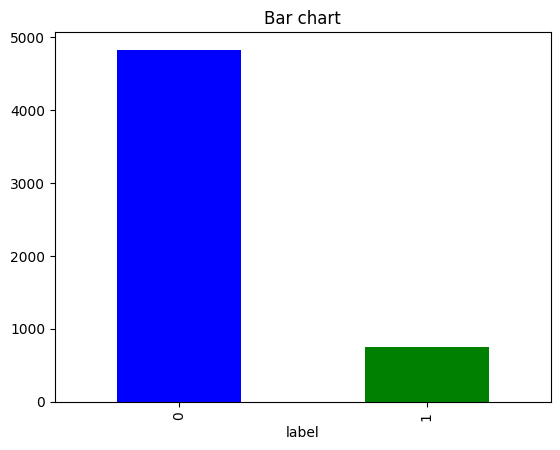

In [3]:
#Hiện thị thông kê dữ liệu cho dữ liệu cột Lable
count_Class=pd.value_counts(df["label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "green"])
plt.title('Bar chart')
plt.show()



```
# This is formatted as code
```

# 1. Tự cài đặt mô hình NB thông thường

Bước 1: tiền xử lí dữ liệu + tạo heuristic

In [4]:
#Tiền xử lí dữ liệu cho model
# === Regex Heuristic ===
url_pattern = re.compile(r'http\S+|www\.\S+')
phone_pattern = re.compile(r'\b\d{9,}\b')  # Số dài 9 chữ số trở lên
money_pattern = re.compile(r'[\$€₫¥£]')

# === Áp dụng Heuristic ===
df['has_url'] = df['message'].apply(lambda x: int(bool(url_pattern.search(str(x)))))
df['has_phone'] = df['message'].apply(lambda x: int(bool(phone_pattern.search(str(x)))))
df['has_money'] = df['message'].apply(lambda x: int(bool(money_pattern.search(str(x)))))
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_text_cleaning(text, stop_words=None):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # 1. Ký tự lặp (aaa, !!!)
    #text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 2. Loại dấu câu (trừ ! ?)
    text = re.sub(f"[{string.punctuation.replace('!', '').replace('?', '')}]", " ", text)

    # 3. ! và ? → token
    text = re.sub(r'!+', ' EXCLAMATION ', text)
    text = re.sub(r'\?+', ' QUESTION ', text)

    # 4. Chuẩn hóa khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Lemmatize + Bỏ stopwords
    words = text.split()
    cleaned_words = []
    for word in words:
        if len(word) > 1 and (stop_words is None or word not in stop_words):
            cleaned_words.append(lemmatizer.lemmatize(word))

    return " ".join(cleaned_words)
df['clean_message'] = df['message'].apply(lambda x: advanced_text_cleaning(x, stop_words=stop_words))

Bước 2: Cài đặt TF-IDF

In [5]:
# Custom TF-IDF Vectorizer implementation with n-grams support
# Thuật toán chạy với dữ liệu số hóa
class CustomTfidfVectorizer:
    def __init__(self, max_features=None, stop_words=None, ngram_range=(1, 1)):
        self.max_features = max_features
        self.stop_words = stop_words if stop_words else set()
        self.ngram_range = ngram_range
        self.vocab = {}
        self.idf = {}

    def _get_ngrams(self, words, n):
        """Generate n-grams from a list of words."""
        return [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]

    def fit(self, documents):
        # Build vocabulary and calculate IDF
        word_counts = Counter()
        doc_counts = Counter()
        n_docs = len(documents)

        # Count word/ngram frequencies and document frequencies
        for doc in documents:
            words = doc.split()
            ngrams = set()
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                if len(words) >= n:
                    ngrams.update(self._get_ngrams(words, n))
            word_counts.update(ngrams)
            doc_counts.update(ngrams)

        # Select top max_features words/ngrams (if specified)
        if self.max_features:
            word_counts = dict(word_counts.most_common(self.max_features))
        else:
            word_counts = dict(word_counts)

        # Build vocabulary (word/ngram -> index)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}

        # Calculate IDF
        for word in self.vocab:
            self.idf[word] = np.log(n_docs / (doc_counts[word] + 1)) + 1  # Smoothing

        return self

    def transform(self, documents):
        # Transform documents to TF-IDF matrix
        n_docs = len(documents)
        n_features = len(self.vocab)
        tfidf_matrix = np.zeros((n_docs, n_features))

        # Calculate TF-IDF for each document
        for i, doc in enumerate(documents):
            words = doc.split()
            ngrams = []
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                if len(words) >= n:
                    ngrams.extend(self._get_ngrams(words, n))
            word_counts = Counter(ngrams)
            total_words = len(ngrams)

            for word, count in word_counts.items():
                if word in self.vocab:
                    tf = count / total_words if total_words > 0 else 0  # Term Frequency
                    tfidf = tf * self.idf[word]  # TF-IDF
                    tfidf_matrix[i, self.vocab[word]] = tfidf

        # Normalize each row (L2 normalization)
        norms = np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid division by zero
        tfidf_matrix = tfidf_matrix / norms

        return tfidf_matrix

    def fit_transform(self, documents):
        return self.fit(documents).transform(documents)
    def get_feature_names_out(self):
      return [word for word, _ in sorted(self.vocab.items(), key=lambda item: item[1])]


Bước 3: áp dụng TF-IDF vào dữ liệu đã xử lí

In [6]:
# Vectorization with TF-IDF
vectorizer = CustomTfidfVectorizer(max_features=3000, stop_words="english", ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_message'])
y = df['label']
# Tạo DataFrame từ TF-IDF matrix
tfidf_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
# Thêm nhãn (label)
tfidf_df['label'] = y
# In full bảng TF-IDF
print(tfidf_df)
print(type(X))


      QUESTION  EXCLAMATION      call  get   ur        go        ok  know  \
0     0.000000     0.000000  0.000000  0.0  0.0  0.193540  0.000000   0.0   
1     0.000000     0.000000  0.000000  0.0  0.0  0.000000  0.238774   0.0   
2     0.000000     0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.0   
3     0.000000     0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.0   
4     0.000000     0.000000  0.000000  0.0  0.0  0.255279  0.000000   0.0   
...        ...          ...       ...  ...  ...       ...       ...   ...   
5567  0.000000     0.082878  0.097649  0.0  0.0  0.000000  0.000000   0.0   
5568  0.169756     0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.0   
5569  0.321323     0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.0   
5570  0.000000     0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.0   
5571  0.000000     0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.0   

      day   gt  ...  sure thing  gay chat  pig  attend  reach home  fever  

Bước 4: Tạo biến lưu kết hợp TF-IDF và Heuristics

In [7]:
from scipy import sparse
X_heuristic = df[['has_url', 'has_phone', 'has_money']].astype(float).values
# Chuyển sang sparse trước khi ghép
X_heuristic_sparse = sparse.csr_matrix(X_heuristic)
X_features = sparse.hstack([X, X_heuristic_sparse]).tocsr() # Convert to CSR matrix
y = df['label'].values  # hoặc .tolist() đều được
print(X_features[:10].toarray())  # In 5 dòng đầu

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.18022346 0.10617272 ... 0.         1.         1.        ]
 [0.06726205 0.07460516 0.08790234 ... 0.         1.         0.        ]]


Bước 5: Cài đặt NB

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score

class CustomNaiveBayesNumeric:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_log_prior_ = None
        self.feature_log_prob_ = {}
        self.classes_ = None

    def fit(self, X, y):
        # Chuyển về dạng dense nếu cần
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.class_log_prior_ = {}
        self.feature_log_prob_ = {}

        for cls in self.classes_:
            X_cls = X[y == cls]
            # Tổng số từ trong lớp (tổng các giá trị của tất cả các đặc trưng)
            total_count = np.sum(X_cls)
            # Tính tổng số lần xuất hiện của từng đặc trưng
            feature_count = np.sum(X_cls, axis=0)

            # Laplace smoothing
            smoothed_fc = feature_count + self.alpha
            smoothed_total = total_count + self.alpha * n_features

            self.feature_log_prob_[cls] = np.log(smoothed_fc / smoothed_total)
            self.class_log_prior_[cls] = np.log(len(X_cls) / len(X))

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        predictions = []
        for x in X:
            log_probs = {}
            for cls in self.classes_:
                log_prob = self.class_log_prior_[cls] + np.dot(x, self.feature_log_prob_[cls])
                log_probs[cls] = log_prob
            predictions.append(max(log_probs, key=log_probs.get))
        return np.array(predictions)


    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

    def get_params(self, deep=True):
        return {"alpha": self.alpha}

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

1.1. Chạy mô hình với dữ liệu TF-IDF

Bước 1: chia tập dữ liệu chỉ gồm TF-IDF

In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Bước 2: Training

In [10]:
# Train Naive Bayes model
nb_model = CustomNaiveBayesNumeric(alpha=1.0)
nb_model.fit(X_train, y_train)

Bước 3: Đánh giá kết quả

In [11]:
#Tính toán các giá trị test
Accuracy=accuracy_score(y_test, nb_model.predict(X_test))
Precision=precision_score(y_test, nb_model.predict(X_test))
Recall=recall_score(y_test, nb_model.predict(X_test))
F1_Score=f1_score(y_test, nb_model.predict(X_test))
print('Accuracy : {:.2f}%'.format(Accuracy*100))
print('Precision : {:.2f}%' .format(Precision*100))
print('Recall : {:.2f}%'.format(Recall*100))
print('F1-Score : {:.2f}%'.format(F1_Score*100))

Accuracy : 98.48%
Precision : 99.19%
Recall : 88.49%
F1-Score : 93.54%


In [13]:
#Tính toán confusion
m_confusion_test = metrics.confusion_matrix(y_test, nb_model.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Dự Đoán (Ham)', 'Dự đoán (Spam)'],
            index = ['Thực tế (Ham)', 'Thực tế (Spam)'])

,Dự Đoán (Ham),Dự đoán (Spam)
Thực tế (Ham),975,1
Thực tế (Spam),16,123


In [14]:
# Predict with Naive Bayes
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9847533632286996
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       976
           1       0.99      0.88      0.94       139

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



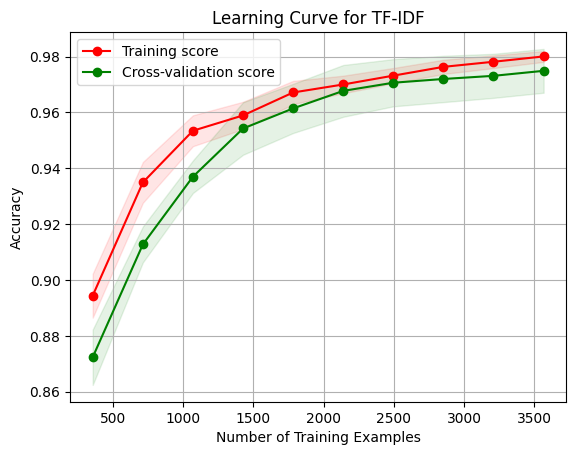

In [15]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Xác định các kích thước tập huấn luyện
train_sizes = np.linspace(0.1, 1.0, 10)

# Tính toán dữ liệu learning curve
train_sizes, train_scores, val_scores = learning_curve(
    nb_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='accuracy'
)

# Tính giá trị trung bình và độ lệch chuẩn
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Vẽ biểu đồ learning curve
plt.figure()
plt.title('Learning Curve for TF-IDF')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

1.2. Chạy mô hình với dữ liệu TF-IDF kết hợp các Heuristics



In [16]:
# Split dataset
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_features, y, test_size=0.2, random_state=1)

In [17]:
# Train Naive Bayes model
nb_model_1 = CustomNaiveBayesNumeric(alpha=1.0)
nb_model_1.fit(X_train_1, y_train_1)

In [18]:
#Tính toán các giá trị test
Accuracy=accuracy_score(y_test_1, nb_model_1.predict(X_test_1))
Precision=precision_score(y_test_1, nb_model_1.predict(X_test_1))
Recall=recall_score(y_test_1, nb_model_1.predict(X_test_1))
F1_Score=f1_score(y_test_1, nb_model_1.predict(X_test_1))
print('Accuracy : {:.2f}%'.format(Accuracy*100))
print('Precision : {:.2f}%' .format(Precision*100))
print('Recall : {:.2f}%'.format(Recall*100))
print('F1-Score : {:.2f}%'.format(F1_Score*100))

Accuracy : 98.83%
Precision : 97.73%
Recall : 92.81%
F1-Score : 95.20%


In [19]:
#Tính toán confusion
m_confusion_test = metrics.confusion_matrix(y_test_1, nb_model_1.predict(X_test_1))
pd.DataFrame(data = m_confusion_test, columns = ['Dự Đoán (Ham)', 'Dự đoán (Spam)'],
            index = ['Thực tế (Ham)', 'Thực tế (Spam)'])

,Dự Đoán (Ham),Dự đoán (Spam)
Thực tế (Ham),973,3
Thực tế (Spam),10,129


In [20]:
# Predict with Naive Bayes
y_pred_nb = nb_model_1.predict(X_test_1)
print("Naive Bayes Accuracy:", accuracy_score(y_test_1, y_pred_nb))
print(classification_report(y_test_1, y_pred_nb))

Naive Bayes Accuracy: 0.9883408071748879
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       976
           1       0.98      0.93      0.95       139

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



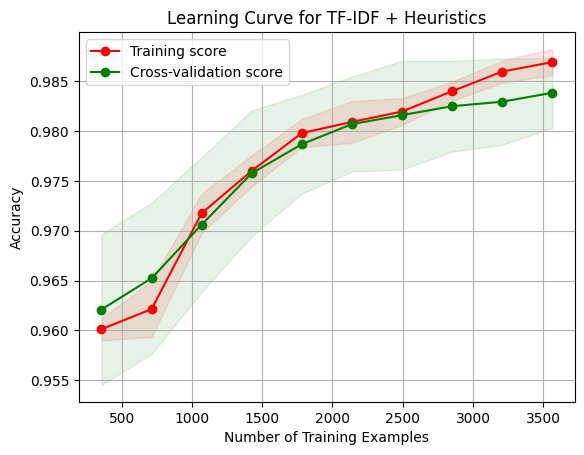

In [21]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Xác định các kích thước tập huấn luyện
train_sizes = np.linspace(0.1, 1.0, 10)

# Tính toán dữ liệu learning curve
train_sizes, train_scores, val_scores = learning_curve(
    nb_model_1, X_train_1, y_train_1, train_sizes=train_sizes, cv=5, scoring='accuracy'
)

# Tính giá trị trung bình và độ lệch chuẩn
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Vẽ biểu đồ learning curve
plt.figure()
plt.title('Learning Curve for TF-IDF + Heuristics')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

#2. Cài đặt thuật toán NB chạy với dữ liệu đầu vào là **String**

> Add blockquote



In [22]:
#Tiền xử lí lại dữ liệu cho model
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_text_cleaning(text, stop_words=None):
    if pd.isna(text):
        return ""

    text = str(text).lower()
    # 1. URL, Email, Phone, Money
    text = re.sub(r'http\S+|www\.\S+', ' URL ', text)
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)
    text = re.sub(r'\b\d{9,}\b', ' PHONE ', text)  # Số >=10 chữ số = phone
    text = re.sub(r'\$\d+(?:\.\d{2})?', ' MONEY ', text)

    # 2. Xử lí ký tự lặp (aaa, !!!)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 3. Loại dấu câu (trừ ! ?)
    #text = re.sub(f"[{string.punctuation.replace('!', '').replace('?', '')}]", " ", text)

    # 4. ! và ? → token
    text = re.sub(r'!+', ' EXCLAMATION ', text)
    text = re.sub(r'\?+', ' QUESTION ', text)

    # 5. Chuẩn hóa khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Lemmatize + Bỏ stopwords
    words = text.split()
    cleaned_words = []
    for word in words:
        if len(word) > 1 and (stop_words is None or word not in stop_words):
            cleaned_words.append(lemmatizer.lemmatize(word))
    return " ".join(cleaned_words)
df['clean_message'] = df['message'].apply(lambda x: advanced_text_cleaning(x, stop_words=stop_words))

In [23]:
# Custom Multinomial Naive Bayes implementation
# Thuật toán chạy với String
class CustomNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Laplace smoothing parameter
        self.class_priors = {}
        self.word_probs = {}  # P(word | class)
        self.vocab = set()

        self.total_spam_words = 0
        self.total_ham_words = 0
        self.vocab_size = 0

    def fit(self, X, y):
        # X: list of cleaned messages, y: list of labels
        #X = df['clean_message'].tolist()
        #y = df['label'].tolist()

        # Tính số lượng mẫu cho mỗi lớp
        n_samples = len(y)
        n_spam = sum(y)
        n_ham = n_samples - n_spam
        self.class_priors[1] = (n_spam + self.alpha) / (n_samples + 2 * self.alpha)  # P(spam)
        self.class_priors[0] = (n_ham + self.alpha) / (n_samples + 2 * self.alpha)  # P(ham)

        # Tính tần suất từ cho mỗi lớp
        spam_words = Counter()
        ham_words = Counter()
        self.total_spam_words = 0
        self.total_ham_words = 0

        for message, label in zip(X, y):
            words = message.split()
            self.vocab.update(words)
            if label == 1:  # Spam
                spam_words.update(words)
                self.total_spam_words += len(words)
            else:  # Ham
                ham_words.update(words)
                self.total_ham_words += len(words)

        # Tính xác suất có điều kiện với Laplace smoothing
        self.vocab_size = len(self.vocab)

        self.word_probs[1] = {word: (spam_words[word] + self.alpha) / (self.total_spam_words + self.vocab_size * self.alpha) for word in self.vocab}
        self.word_probs[0] = {word: (ham_words[word] + self.alpha) / (self.total_ham_words + self.vocab_size * self.alpha) for word in self.vocab}

    def predict(self, X):
        predictions = []
        for message in X:
            words = message.split()
            # Tính log-probability để tránh underflow
            log_prob_spam = np.log(self.class_priors[1])
            log_prob_ham = np.log(self.class_priors[0])

            for word in words:
                if word in self.vocab:
                    log_prob_spam += np.log(self.word_probs[1].get(word, self.alpha / (self.total_spam_words + self.vocab_size * self.alpha)))
                    log_prob_ham += np.log(self.word_probs[0].get(word, self.alpha / (self.total_ham_words + self.vocab_size * self.alpha)))

            # Chọn lớp có log-probability cao hơn
            predictions.append(1 if log_prob_spam > log_prob_ham else 0)
        return np.array(predictions)
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    def get_params(self, deep=True):
        return {"alpha": self.alpha}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [24]:
X_1 = df['clean_message'].tolist()
y_1 = df['label'].tolist()
df_preview = pd.DataFrame({'Text': X_1, 'Label': y_1})
print(df_preview.head(10))  # Xem 10 dòng đầu

                                                Text  Label
0  go jurong point, crazy.. available bugis great...      0
1                          ok lar.. joking wif oni..      0
2  free entry wkly comp win fa cup final tkts 21s...      1
3                  dun say early hor.. already say..      0
4               nah think go usf, life around though      0
5  freemsg hey darling week's word back EXCLAMATI...      1
6  even brother like speak me. treat like aid pat...      0
7  per request 'melle melle (oru minnaminunginte ...      0
8  winner EXCLAMATION valued network customer sel...      1
9  mobile 11 month QUESTION entitled update lates...      1


In [25]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=1)

In [26]:
# Train Naive Bayes model
nb_model_2 = CustomNaiveBayes(alpha=1.0)
nb_model_2.fit(X_train, y_train)

In [27]:
#Tính toán các giá trị test
Accuracy=accuracy_score(y_test, nb_model_2.predict(X_test))
Precision=precision_score(y_test, nb_model_2.predict(X_test))
Recall=recall_score(y_test, nb_model_2.predict(X_test))
F1_Score=f1_score(y_test, nb_model_2.predict(X_test))
print('Accuracy : {:.2f}%'.format(Accuracy*100))
print('Precision : {:.2f}%' .format(Precision*100))
print('Recall : {:.2f}%'.format(Recall*100))
print('F1-Score : {:.2f}%'.format(F1_Score*100))

Accuracy : 99.10%
Precision : 98.50%
Recall : 94.24%
F1-Score : 96.32%


In [28]:
#Tính toán confusion
m_confusion_test = metrics.confusion_matrix(y_test, nb_model_2.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Dự Đoán (Ham)', 'Dự đoán (Spam)'],
            index = ['Thực tế (Ham)', 'Thực tế (Spam)'])

,Dự Đoán (Ham),Dự đoán (Spam)
Thực tế (Ham),974,2
Thực tế (Spam),8,131


In [29]:
# Predict with Naive Bayes
y_pred_nb = nb_model_2.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9910313901345291
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       976
           1       0.98      0.94      0.96       139

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [30]:
# Convert back to list for CustomNaiveBayes
X_train_list = X_train
X_test_list = X_test

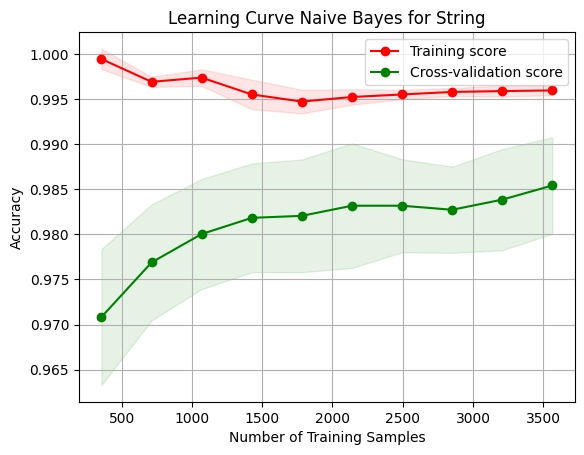

In [31]:
# Định nghĩa range cho training size
train_sizes = np.linspace(0.1, 1.0, 10)

# Sử dụng learning curve cho SVM model
train_sizes, train_scores, val_scores = learning_curve(nb_model_2, X_train_list, y_train, train_sizes=train_sizes, cv=5)

# Tính giá trị trung bình và độ lệch cho training và validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Vẽ curve
plt.figure()
plt.title('Learning Curve Naive Bayes for String')
plt.ylabel("Accuracy")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Number of Training Samples")
plt.show()

#3. DEMO

In [32]:
def predict_message(message):
    # Bước 1: Làm sạch tin nhắn
    cleaned_message = advanced_text_cleaning(message, stop_words=stop_words)

    # Bước 2: Vector hóa tin nhắn bằng CustomTfidfVectorizer
    cleaned_message_vectorized = vectorizer.transform([cleaned_message])

    # Bước 3: Tính các đặc trưng heuristic (has_url, has_phone, has_money)
    url_pattern = re.compile(r'http\S+|www\.\S+')
    phone_pattern = re.compile(r'\b\d{9,}\b')
    money_pattern = re.compile(r'[\$€₫¥£]')

    has_url = int(bool(url_pattern.search(str(message))))
    has_phone = int(bool(phone_pattern.search(str(message))))
    has_money = int(bool(money_pattern.search(str(message))))

    heuristic_features = np.array([has_url, has_phone, has_money]).reshape(1, -1)
    heuristic_features_sparse = sparse.csr_matrix(heuristic_features)

    # Bước 4: Ghép đặc trưng TF-IDF và heuristic thành ma trận giống X_features
    X_new = sparse.hstack([cleaned_message_vectorized, heuristic_features_sparse])
    # Naive Bayes with String
    nb2_pred = nb_model_2.predict([cleaned_message])[0]
    # TF-IDF + heuristics
    nb1_pred = nb_model_1.predict(X_new)[0] # Removed .toarray()
    # TF-IDF
    nb_pred = nb_model.predict(cleaned_message_vectorized)[0] # Removed .toarray()
    # Return results
    print(f"\nMessage: {message}")
    print(f"Naive Bayes for String Prediction: {'Spam' if nb2_pred == 1 else 'Ham'}")
    print(f"Naive Bayes for TF-IDF Prediction: {'Spam' if nb_pred == 1 else 'Ham'}") # Changed svm_pred to nb_pred
    print(f"Naive Bayes for TF-IDF + Heuristics Prediction: {'Spam' if nb1_pred == 1 else 'Ham'}")

while True:
    user_input = input("\nEnter a message to test (or 'exit' to stop): ")
    if user_input.lower() == 'exit':
        break
    predict_message(user_input)


Enter a message to test (or 'exit' to stop): exit
